In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
import copy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

from mordred import Calculator, descriptors, Lipinski
import mordred

# import mlflow
# from mlflow.models.signature import infer_signature
# from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

import logging

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import logging 
import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False
import sys
logging.basicConfig(stream=sys.stdout)
logger = logging.getLogger(name=__name__)
logger.setLevel(logging.DEBUG)

In [2]:
logger.info(os.environ['CONDA_DEFAULT_ENV'])
logger.info(os.getcwd())

INFO:__main__:qsarmodeler
INFO:__main__:c:\Users\rbachorz\Projects\qsarmodeler\qsarmodeler\notebooks


# Helper functions

In [3]:
def get_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        levs = list(set(y.tolist()))
        if len(levs) == 1:
            return levs[0]
        else:
            return 'mix'

def get_all_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return sorted(y.tolist())
        #return sorted(list(set(y.tolist())))
                
def get_mean(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return np.mean(y)
    
def initialize_seeds(random_seed):
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    rn.seed(random_seed)
    
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)
    
def connect2DB(user="admin", password="secret", host="localhost", port="15432", database="chembl"):
    connection = psycopg2.connect(user=user,
                    password=password,
                    host=host,
                    port=port,
                    database=database)
    return connection

# Database connection

In [4]:
con = connect2DB()
cursor = con.cursor()
cursor.execute("select * from target_dictionary as tardi \
where tardi.pref_name like '%ROR%'")

In [8]:
logger.info("list of ROR-like receptors in the ChEMBL database...")
pd.DataFrame(cursor.fetchall())

INFO:__main__:list of ROR-like receptors in the ChEMBL database...


,0,1,2,3,4,5,6
0,101591,SINGLE PROTEIN,Nuclear receptor ROR-alpha,9606,Homo sapiens,CHEMBL5868,0
1,103664,SINGLE PROTEIN,Nuclear receptor ROR-gamma,10090,Mus musculus,CHEMBL1293231,0
2,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0
3,105356,SINGLE PROTEIN,Tyrosine-protein kinase transmembrane receptor...,10090,Mus musculus,CHEMBL2176781,0
4,107581,SINGLE PROTEIN,Tyrosine-protein kinase transmembrane receptor...,9606,Homo sapiens,CHEMBL2375201,0
5,107979,SINGLE PROTEIN,Nuclear receptor ROR-beta,9606,Homo sapiens,CHEMBL3091268,0
6,108261,SINGLE PROTEIN,Nuclear receptor ROR-alpha,10090,Mus musculus,CHEMBL3217403,0
7,117326,SINGLE PROTEIN,Nuclear receptor ROR-beta,10116,Rattus norvegicus,CHEMBL4105721,0
8,120078,SINGLE PROTEIN,Inactive tyrosine-protein kinase transmembrane...,9606,Homo sapiens,CHEMBL4665585,0


In [6]:
#cursor = con.cursor()
#cursor.execute("select * from ( \
#select * from activities as act \
#inner join assays as assays on act.assay_id=assays.assay_id inner join target_dictionary as tardi on assays.tid=tardi.tid \
#inner join compound_structures as cs on act.molregno=cs.molregno \
#where tardi.pref_name like '%ROR%') as combined")

* RORgamma - homo sapiens

In [9]:
def create_query(receptor):
    query = "select * from ( \
    select * from activities as act \
    inner join assays as assays on act.assay_id=assays.assay_id \
    left join docs as docs on act.doc_id=docs.doc_id \
    join target_dictionary as tardi on assays.tid=tardi.tid \
    inner join compound_structures as cs on act.molregno=cs.molregno \
    inner join compound_properties as cp on act.molregno=cp.molregno \
    left join molecule_dictionary as md on act.molregno=md.molregno \
    left join ligand_eff as le on act.activity_id=le.activity_id \
    where tardi.chembl_id in ('"+receptor+"')) as combined"
    return query

In [10]:
# ROR gamma homo sapiens
rorgamma_homo_sapiens_receptor = "CHEMBL1741186"
# ROR gamma mus musculus
rorgamma_mus_musculus_receptor = "CHEMBL1293231"
# Androgen receptor
rorgamma_mus_musculus_receptor = "CHEMBL1871"


query = create_query(rorgamma_homo_sapiens_receptor)
cursor = con.cursor()
cursor.execute(query)

data = pd.DataFrame(cursor.fetchall())
colnames = [desc[0] for desc in cursor.description]
data.columns = colnames

con.close()

In [11]:
data.head()

,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,activity_comment,data_validity_comment,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,tid,relationship_type,confidence_score,curated_by,src_id,src_assay_id,chembl_id,cell_id,bao_format,tissue_id,variant_id,aidx,doc_id,journal,year,volume,issue,first_page,last_page,pubmed_id,doi,chembl_id,title,doc_type,authors,abstract,patent_id,ridx,src_id,tid,target_type,pref_name,tax_id,organism,chembl_id,species_group_flag,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class,activity_id,bei,sei,le,lle
0,12652363,939946,72015,1852881,1520596,None,None,%,0,Inhibition,Active,None,0,None,BAO_0000201,UO_0000187,http://qudt.org/vocab/unit#Percent,None,None,None,1,INH,None,None,None,None,None,939946,72015,Antagonist activity RORgammat in human Th17 ce...,B,None,None,Homo sapiens,9606.0,None,None,Th17,None,103982,D,9,Autocuration,1,552075,CHEMBL2327328,NaN,BAO_0000219,NaN,NaN,CLD0,72015,ACS Med. Chem. Lett.,2013.0,4,1,79,84,24040486.0,10.1021/ml300286h,CHEMBL2321802,Identification of Potent and Selective Dipheny...,PUBLICATION,"Huh JR, Englund EE, Wang H, Huang R, Huang P, ...",Retinoic acid-related orphan receptor RORγt pl...,None,CLD0,1,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1520596,\n RDKit 2D\n\n 32 35 0 0 0 0...,InChI=1S/C25H31NO6/c1-15-7-16(2)13-26(12-15)24...,YEKVAIMYYCZDLI-MCPYQZEQSA-N,COc1cc(O)c(C(CC(=O)N2C[C@@H](C)C[C@@H](C)C2)c2...,1520596,441.52,4.16,6.0,1.0,77.46,6.0,N,0.0,9.22,None,3.70,3.69,NEUTRAL,441.52,2.0,32.0,0.73,441.2151,C25H31NO6,7.0,1.0,0.0,1520596,None,CHEMBL2326408,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0.0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
1,5980337,737070,51887,1381757,1092851,=,2080.0,nM,1,IC50,Active,None,0,5.68,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,=,2.08,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,103982,H,8,Autocuration,7,2117_2,CHEMBL1738628,NaN,BAO_0000019,NaN,NaN,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1092851,\n RDKit 2D\n\n 30 32 0 0 0 0...,InChI=1S/C15H8ClF6N3O4S/c16-9-5-6-10(12-11(9)2...,DVUUFKVQAGWFAF-UHFFFAOYSA-N,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,1092851,475.75,3.99,6.0,2.0,105.32,4.0,N,0.0,6.56,None,3.54,2.63,NEUTRAL,475.75,3.0,30.0,0.55,474.9828,C15H8ClF6N3O4S,7.0,2.0,0.0,1092851,None,CHEMBL1712120,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0.0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
2,5980338,737070,51887,1381756,1099175,>,20000.0,nM,1,IC50,inactive,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,>,20.0,um,None,None,7

* rename the chembl_id columns 

In [10]:
chembl_idx = [item[0] for item in enumerate(data.columns) if item[1].startswith('chembl_id')]
chembl_idx_labels = ['chembl_id_assay', 'chembl_id_doc', 'chembl_id_target', 'chembl_id_compound']

In [11]:
chembl_idx

[45, 60, 73, 105]

In [12]:
tmp = data.columns.tolist()
for i,idx in enumerate(chembl_idx):
    tmp[idx] = chembl_idx_labels[i]
data.columns = tmp

In [13]:
data.head()

,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,activity_comment,data_validity_comment,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,tid,relationship_type,confidence_score,curated_by,src_id,src_assay_id,chembl_id_assay,cell_id,bao_format,tissue_id,variant_id,aidx,doc_id,journal,year,volume,issue,first_page,last_page,pubmed_id,doi,chembl_id_doc,title,doc_type,authors,abstract,patent_id,ridx,src_id,tid,target_type,pref_name,tax_id,organism,chembl_id_target,species_group_flag,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molregno,pref_name,chembl_id_compound,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class,activity_id,bei,sei,le,lle
0,11456733,845157,51887,1710289,1409150,None,220.0,nM,1,IC50,probe,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,None,0.22,uM,None,None,845157,51887,PubChem BioAssay. Late stage assay provider co...,F,None,confirmatory,Homo sapiens,9606.0,None,None,None,None,103982,D,9,Autocuration,7,624276,CHEMBL2114768,NaN,BAO_0000019,NaN,NaN,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1409150,\n RDKit 2D\n\n 37 40 0 0 0 0...,"InChI=1S/C26H24F7N3O/c27-23-15-21(24(37,25(28,...",KVHKWAZUPPBMLL-UHFFFAOYSA-N,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,1409150,527.48,5.52,4.0,1.0,39.60,6.0,N,2.0,7.17,7.83,4.27,4.40,NEUTRAL,527.48,3.0,37.0,0.43,527.1808,C26H24F7N3O,4.0,1.0,2.0,1409150,None,CHEMBL2137199,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
1,5980337,737070,51887,1381757,1092851,=,2080.0,nM,1,IC50,Active,None,0,5.68,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,=,2.08,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,103982,H,8,Autocuration,7,2117_2,CHEMBL1738628,NaN,BAO_0000019,NaN,NaN,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1092851,\n RDKit 2D\n\n 30 32 0 0 0 0...,InChI=1S/C15H8ClF6N3O4S/c16-9-5-6-10(12-11(9)2...,DVUUFKVQAGWFAF-UHFFFAOYSA-N,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,1092851,475.75,3.99,6.0,2.0,105.32,4.0,N,0.0,6.56,None,3.54,2.63,NEUTRAL,475.75,3.0,30.0,0.55,474.9828,C15H8ClF6N3O4S,7.0,2.0,0.0,1092851,None,CHEMBL1712120,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
2,11964097,845231,51887,1011104,950620,None,5955.7,nM,1,Potency,active,None,0,None,BAO_0000186,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,Potency,None,5.9557,uM,None,None,845231,51887,PubChem BioAssay. qHTS assay for small molecul...,F,None,confirmatory,Homo sapiens,9606.0,N

In [14]:
data.shape

(7307, 139)

* remove the duplicated columns 

In [15]:
data = data.T.drop_duplicates().T

In [16]:
data.shape

(7307, 124)

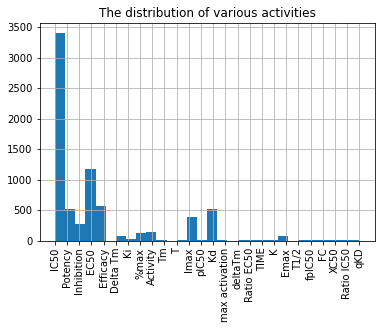

In [26]:
data['standard_type'].hist(bins=30)
plt.title("The distribution of various activities")
plt.xticks(rotation=90)
plt.savefig(fname="activities_distribution.pdf", format="pdf", dpi=200, bbox_inches='tight')#, pad_inches=2)

* remove tha rows for which the 'standard_value' and 'standard_units' is nan

In [19]:
data[pd.isna(data['standard_value'])].shape

(327, 124)

In [20]:
data[pd.isna(data['standard_units'])].shape

(321, 124)

In [21]:
data = data[~pd.isna(data['standard_value'])]
data = data[~pd.isna(data['standard_units'])]
data.shape

(6960, 124)

In [22]:
data[data["standard_type"]=="IC50"].groupby("molregno").count()["standard_value"].value_counts()

1     1935
2      413
3       84
4       21
5        7
6        3
8        2
13       2
15       1
11       1
7        1
9        1
12       1
Name: standard_value, dtype: int64

In [23]:
data[data["standard_type"]=="IC50"].groupby("molregno").count()

,activity_id,assay_id,doc_id,record_id,standard_relation,standard_value,standard_units,standard_flag,standard_type,activity_comment,data_validity_comment,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,src_id,type,relation,value,units,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_tissue,assay_cell_type,tid,relationship_type,confidence_score,curated_by,src_assay_id,chembl_id_assay,cell_id,bao_format,tissue_id,variant_id,aidx,journal,year,volume,issue,first_page,last_page,pubmed_id,doi,chembl_id_doc,title,doc_type,authors,abstract,patent_id,ridx,target_type,pref_name,tax_id,organism,chembl_id_target,species_group_flag,molfile,standard_inchi,standard_inchi_key,canonical_smiles,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,pref_name,chembl_id_compound,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class,activity_id,bei,sei,le,lle
molregno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2208,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1
40459,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92776,15,15,15,15,15,15,15,15,15,1,0,15,15,15,15,15,0,0,15,15,15,15,13,15,15,0,1,14,14,0,6,15,15,15,15,13,15,3,15,0,0,15,14,14,14,11,14,14,13,14,15,15,15,14,13,0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,15,0,15,15,15,15,15,15,15,15,15,0,15,0,0,0,0,15,0,0,0,0,14,14,14,14,14
155592,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
201200,4,4,4,4,4,4,4,4,4,0,0,4,4,4,4,4,0,0,4,4,4,4,4,4,4,0,0,4,4,0,2,4,4,4,4,4,4,0,4,0,0,4,4,4,4,1,4,4,3,4,4,4,4,4,3,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,0,0,0,0,0,0,4,0,0,0,0,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536694,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1
2536937,2,2,2,2,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,0,0,2,2,1,2,2,2,2,2,0,2,0,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,0,0,0,2,2,2,2,2,2,2,2,2,0,2,0,0,0,0,2,0,0,0,0,2,2,2,2,2
2536979,2,2,2,2,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2

* take only the chosen type, e.g. the IC50 values

In [24]:
aggFunctions = {
    'standard_value': ['min', 'max', get_all_levels, get_mean],
    'standard_units': [get_levels, get_all_levels],
    'standard_type': get_levels,
    'activity_comment': get_levels,
    'type': get_levels,
    'chembl_id_compound': get_levels,
    'full_mwt': 'min',
    'canonical_smiles': get_levels
}

def expand_activity(x):
    expanded = [None for iii in range(max_level_activity)]
    n_act = len(x)
    expanded[:n_act] = x[:n_act]
    return np.array(expanded)

In [25]:
raw_types = data["standard_type"].unique().tolist()
clean_types = [item.replace(" ", "").replace("/", "").replace("%", "") for item in raw_types]

In [26]:
chosen_type = "IC50"
all_results = {} 
for chosen_type, clean_type in zip(raw_types, clean_types):
    data_slice = copy.deepcopy(data[data["standard_type"]==chosen_type])

    data_grouped = data_slice.groupby('molregno')
    data_aggregated = data_grouped.agg(aggFunctions)
    max_level_activity = max(data_aggregated[("standard_value", "get_all_levels")].apply(lambda x: len(x)))
    #print("shape ", data_aggregated.shape)
    #print("max_level_activity ", max_level_activity)
    data_aggregated.columns = [str(item[0])+"_"+str(item[1]) for item in data_aggregated.columns.to_flat_index().to_list()]

    all_activities = data_aggregated[("standard_value_get_all_levels")].apply(lambda x: expand_activity(x))
    all_activities = pd.DataFrame(all_activities.to_list(), columns=["act_"+str(iii) for iii in range(max_level_activity)])
    all_activities = all_activities.set_index(data_aggregated.index)

    data_aggregated = pd.concat([data_aggregated, all_activities], axis=1)
    data_aggregated = data_aggregated.drop(["standard_value_get_all_levels", "standard_units_get_all_levels", "standard_value_min",
                                            "standard_value_max", "standard_value_max", "activity_comment_get_levels",
                                            "type_get_levels", "full_mwt_min"], axis=1)
    data_aggregated.to_csv("ror_gamma_homo_sapiens_chembl_3.0_"+clean_type+".csv", index=True)
    all_results[clean_type] = data_aggregated
    print(data_aggregated.shape)

(495, 7)
(2472, 20)
(178, 10)
(875, 11)
(416, 9)
(62, 9)
(16, 7)
(110, 8)
(1, 6)
(53, 8)
(4, 6)
(241, 9)
(382, 11)
(3, 6)
(2, 6)
(2, 7)
(42, 7)
(5, 6)
(13, 6)
(2, 6)


In [27]:
ic50_data = pd.read_csv("ror_gamma_homo_sapiens_chembl_3.0_IC50.csv")
ic50_data
#ic50_data[~pd.isna(ic50_data["act_12"])]

,molregno,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,act_13,act_14
0,2208,199.530000,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40459,31900.000000,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92776,1770.094667,nM,IC50,CHEMBL62136,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,60.00,60.0,204.0,316.23,330.0,501.19,540.0,1700.0,1700.0,1730.0,2010.0,3000.0,3500.0,4400.0,6500.0
3,155592,10000.000000,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201200,2820.000000,nM,IC50,CHEMBL169,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C...,130.00,680.0,1060.0,9410.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2467,2536694,239.000000,nM,IC50,CHEMBL4800103,O=C(O)Cc1ccc(CNC(=O)Nc2cc(Cl)c(-c3ccccc3OC(F)(...,239.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2468,2536937,419.000000,nM,IC50,CHEMBL4800346,CCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(OC)ncnc4C4CC4...,98.00,740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,2536979,44.500000,nM,IC50,CHEMBL4800388,CCCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(C)ncnc4C4CC4...,15.00,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2470,2537316,340.000000,mix,IC50,CHEMBL4802041,COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...,10.00,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data[(data["molregno"]==92776) & (data["standard_type"]=="IC50")]["standard_value"]

5       1730.0
729       60.0
977     1700.0
1029     540.0
1052    3500.0
1210    2010.0
1330    6500.0
1413    501.19
1420    316.23
1599    1700.0
1628      60.0
2328    3000.0
2556     204.0
4824    4400.0
5884     330.0
Name: standard_value, dtype: object

In [28]:
all_results["IC50"]

,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,act_13,act_14
molregno,,,,,,,,,,,,,,,,,,,,
2208,199.530000,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,None,None,None,None,None,None,None,None,None,None,None,None,None,None
40459,31900.000000,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
92776,1770.094667,nM,IC50,CHEMBL62136,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,60.0,60.0,204.0,316.23,330.0,501.19,540.0,1700.0,1700.0,1730.0,2010.0,3000.0,3500.0,4400.0,6500.0
155592,10000.000000,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
201200,2820.000000,nM,IC50,CHEMBL169,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C...,130.0,680.0,1060.0,9410.0,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536694,239.000000,nM,IC50,CHEMBL4800103,O=C(O)Cc1ccc(CNC(=O)Nc2cc(Cl)c(-c3ccccc3OC(F)(...,239.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2536937,419.000000,nM,IC50,CHEMBL4800346,CCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(OC)ncnc4C4CC4...,98.0,740.0,None,None,None,None,None,None,None,None,None,None,None,None,None
2536979,44.500000,nM,IC50,CHEMBL4800388,CCCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(C)ncnc4C4CC4...,15.0,74.0,None,None,None,None,None,None,None,None,None,None,None,None,None


<function matplotlib.pyplot.show(close=None, block=None)>

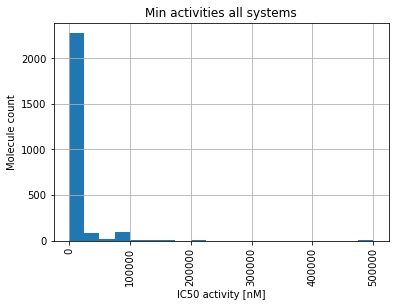

In [29]:
all_results["IC50"]["act_0"].hist(bins=20)
plt.xticks(rotation='vertical')
plt.title('Min activities all systems')
plt.xlabel('IC50 activity [nM]')
plt.ylabel('Molecule count')
plt.show

Text(0, 0.5, 'Molecule count')

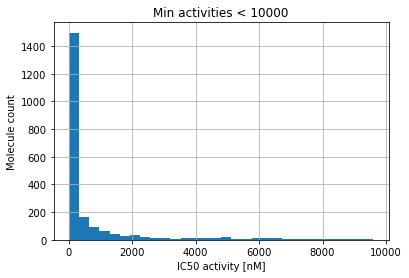

In [30]:
threshold = 10000
all_results["IC50"][all_results["IC50"]["act_0"] < threshold]["act_0"].hist(bins=30)
plt.title('Min activities < '+str(threshold))
plt.xlabel('IC50 activity [nM]')
plt.ylabel('Molecule count')